<a href="https://colab.research.google.com/github/jfb10d/ml-practice/blob/main/notebooks/time_series_forecast_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap
!pip install xgboost
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 266.0 kB/s eta 0:00:00


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# %matplotlib inline
# from pylab import *
line_width = 250
pd.set_option('display.width', line_width, 'display.max_columns', 20, 'display.max_rows', 10, 'display.precision', 2)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/ml_data/data.csv', index_col=0)
data.index = data.index.map(pd.to_datetime)

Data Preprocessing

In [5]:
data.describe()
# measurement A is probably the wind speed measurement
# forecast A-E is probably some forecasted meteorological variables
# forecast A looks like forecasted wind direction

,Wind power measurements,Measurement A,Forecast A,Forecast B,Forecast C,Forecast D,Forecast E
count,6480.00,6480.00,6480.00,6480.00,6480.00,6480.00,6480.00
mean,1646.07,9.42,239.47,7.82,94575.58,9.12,264.97
std,1047.13,4.21,73.33,3.28,823.12,4.23,7.49
min,0.00,0.40,0.11,0.34,92361.59,0.08,243.17
25%,586.50,6.20,197.40,5.48,93971.88,5.75,260.16
50%,1875.95,9.00,240.50,7.54,94624.63,9.05,264.83
75%,2588.92,12.40,299.93,10.24,95101.35,12.27,270.18
max,3075.00,22.10,359.93,18.20,96612.98,21.65,285.40


The data displayed above contains 7 time series.
Data is munged already (interpolated to 10min resolution, filling in any missing values), so they are ready to be analyzed.
The first 2 columns contain measurements, the other 5 columns contain forecasts.

This assignment consists of a number of exercises. The background is that we want to train a model that computes a 10hr-ahead forecast of wind power (so the 1st column).
For all exercises, let’s assume: -
- measurements come in real-time (without any lag), so say at 11am, so when forecasting the amount of wind power for 9pm, you have measurements until 11am available to you. Later measurements obviously did not come in yet.
- forecasts are however available to you any amount of time ahead. So at 11 am you will have weather forecasts for 9pm available to you.

Good luck with the exercises!

Exercise 1:
Plot wind power measurements along with the 6 other time series

Text(0.5, 0, 'Timestamp')

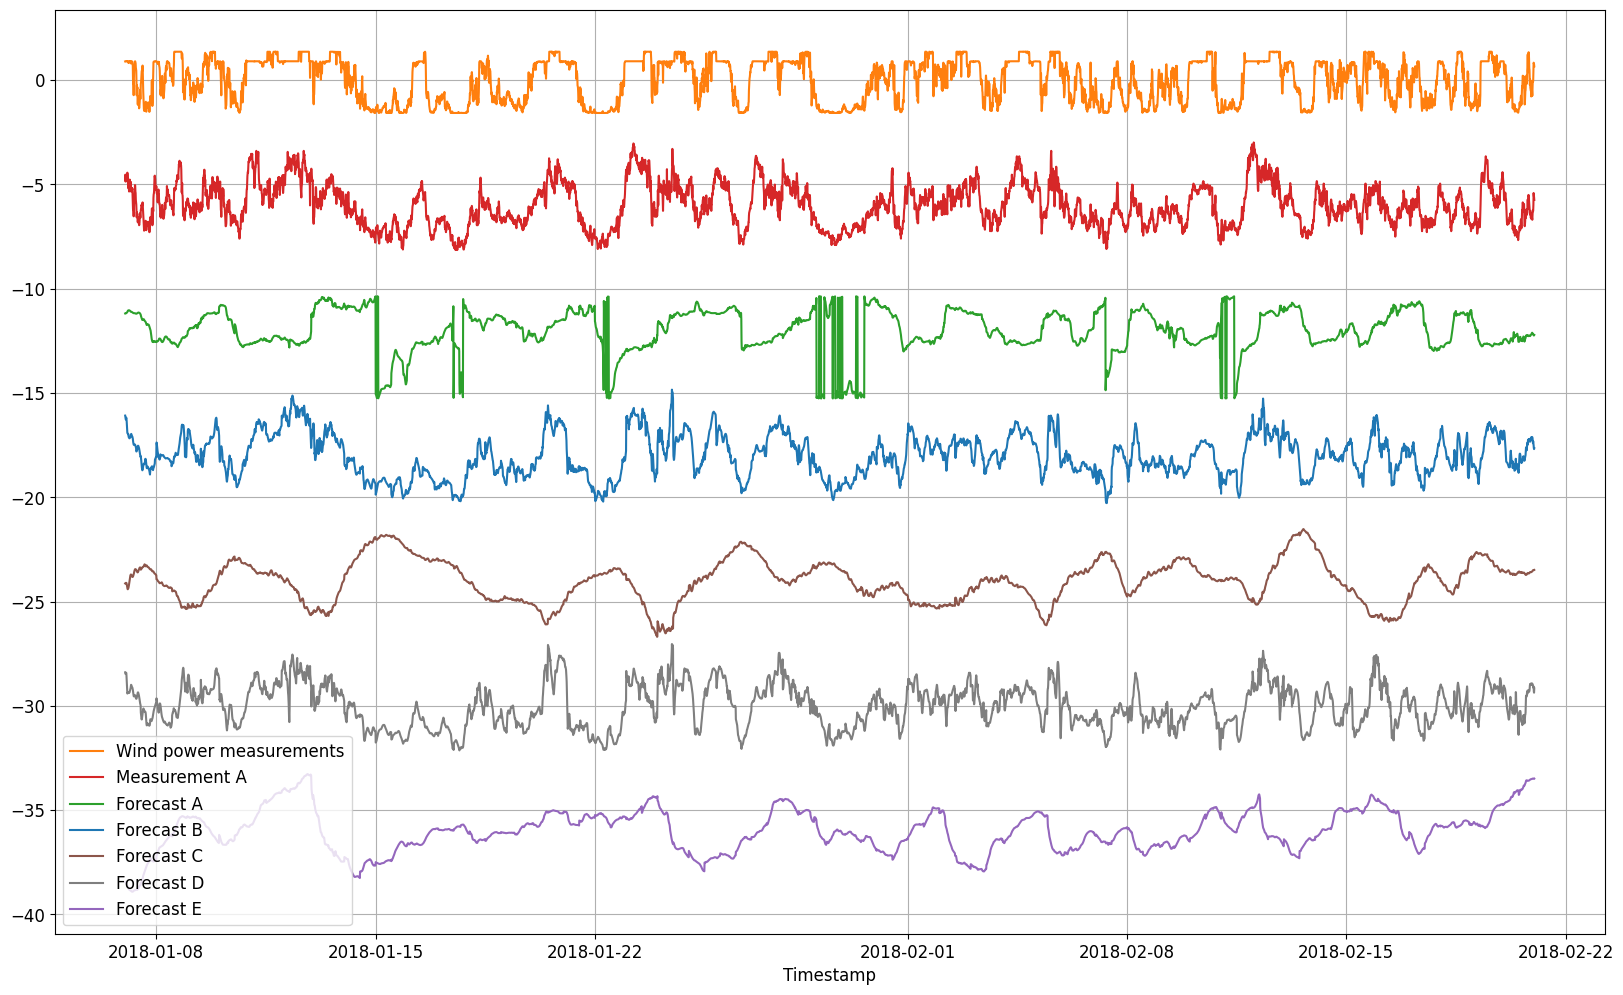

In [7]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 12))

# define line colors
line_color = ['orange', 'red', 'green', 'blue', 'brown', 'gray', 'purple']

# plot each normalized time series, separated by some distance (2)
ref = 0
for column,color in zip(data.columns, line_color):
    # Specify each line
    ax.plot(data.index, (data[column]-data[column].mean())/data[column].std()-ref, color=f'tab:{color}', label=column)
    ref += 6

plt.legend(loc='lower left')
plt.grid()
plt.xlabel('Timestamp')

0


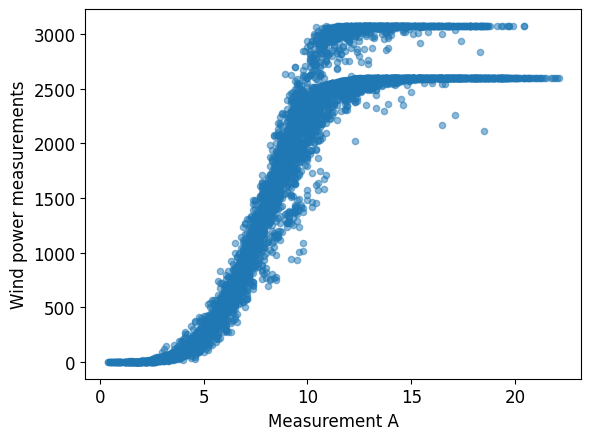

In [8]:
data.plot(kind='scatter',x='Measurement A', y='Wind power measurements',alpha=0.5)
# 2 plateaus in power curve
# The top one likely correspond to the capacity of the turbine, while the bottom
# one is likely artificial due to curtailment
print(data['Wind power measurements'].isnull().sum())

In [71]:
data['cleaned_Wind_power_measurements'] = data['Wind power measurements'].copy()
data['power_diff'] = data['Wind power measurements'].diff()
data.loc[(data['power_diff']==0) & (data['cleaned_Wind_power_measurements']<3000), 'cleaned_Wind_power_measurements']=np.nan

443


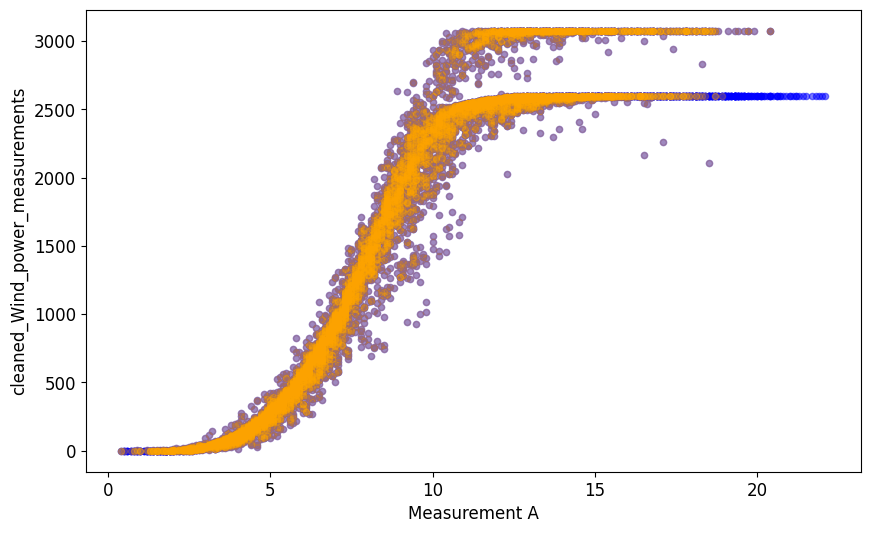

In [72]:
# check power curve again
fig,ax = plt.subplots(figsize=(10,6))
data.plot(kind='scatter',x='Measurement A', y='Wind power measurements',alpha=0.5,ax=ax,color='b')
data.plot(kind='scatter',x='Measurement A', y='cleaned_Wind_power_measurements',alpha=0.25,ax=ax,color='orange')
print(data['cleaned_Wind_power_measurements'].isnull().sum())

In [73]:
# crude cleaning of the bottom plateau
data.loc[(data['Measurement A']>10) & (data['Wind power measurements']<2600), 'cleaned_Wind_power_measurements']=np.nan
print(data['cleaned_Wind_power_measurements'].isnull().sum())

1972


1972


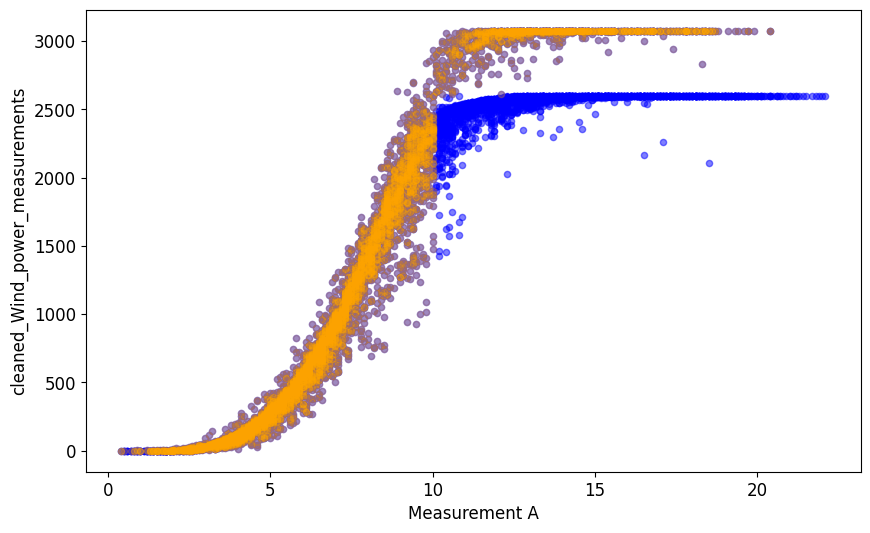

In [74]:
# check power curve again
fig,ax = plt.subplots(figsize=(10,6))
data.plot(kind='scatter',x='Measurement A', y='Wind power measurements',alpha=0.5,ax=ax,color='b')
data.plot(kind='scatter',x='Measurement A', y='cleaned_Wind_power_measurements',alpha=0.25,ax=ax,color='orange')
print(data['cleaned_Wind_power_measurements'].isnull().sum())

Exercise 2: Explore which of the 7 features are potential predictors for 10hr ahead forecasting. Describe clearly how you come to your conclusion.

In [77]:
# shift meansurement A by 10 hours because we want to see if measurement A
# provide any benefits in predicting wind power at T+10 hours
data['Meansurement_A_T-10'] = data['Measurement A'].shift(periods=10*6)
data.drop(columns=['Measurement A'],inplace=True)
data.head()

,Wind power measurements,Forecast A,Forecast B,Forecast C,Forecast D,Forecast E,cleaned_Wind_power_measurements,power_diff,Meansurement_A_T-10
timestamp,,,,,,,,,
2018-01-07 00:10:00+00:00,2590.8,299.28,14.11,94468.10,15.92,246.69,NaN,NaN,NaN
2018-01-07 00:20:00+00:00,2595.1,299.68,13.85,94478.52,15.62,246.63,NaN,4.3,NaN
2018-01-07 00:30:00+00:00,2586.3,299.95,13.71,94487.30,15.66,246.53,NaN,-8.8,NaN
2018-01-07 00:40:00+00:00,2593.5,300.33,13.50,94489.79,15.66,246.41,NaN,7.2,NaN
2018-01-07 00:50:00+00:00,2595.6,299.84,13.64,94489.27,15.76,246.30,NaN,2.1,NaN


Feature Engineering

In [143]:
# since forecast A is wind direction, we need to apply cosine transformation to
# elinimate the discontinuity near northerly winds
data['cos_Forecast A'] = np.cos(np.deg2rad(data['Forecast A']))
data['sin_Forecast A'] = np.sin(np.deg2rad(data['Forecast A']))
data.drop(columns=['Forecast A'],inplace=True)

In [79]:
data.dropna(inplace=True)

<Axes: xlabel='hour'>

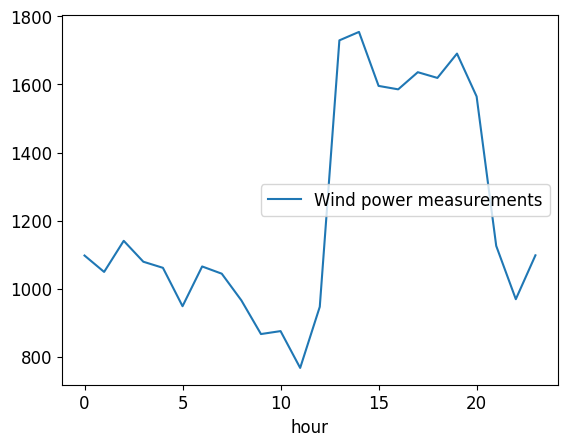

In [80]:
# diurnal cycle of data
data['hour'] = data.index.hour
data.groupby('hour').agg({'Wind power measurements':'mean'}).plot()

In [120]:
# add hour of day features
data['cos_hour'] = np.sin(data.hour*(2.*np.pi/24))
data['sin_hour'] = np.cos(data.hour*(2.*np.pi/24))
data.drop(columns=['hour'],inplace=True)

In [108]:
len(data)

4492

In [144]:
# set aside last 24 hours for testing
y_train = data['cleaned_Wind_power_measurements'].iloc[:-24*6]
X_train = data.drop(columns=['cleaned_Wind_power_measurements', 'Wind power measurements','power_diff']).iloc[:-24*6]
y_test = data['cleaned_Wind_power_measurements'].iloc[-24*6:]
X_test = data.drop(columns=['cleaned_Wind_power_measurements', 'Wind power measurements','power_diff']).iloc[-24*6:]
X_train.head()

,Forecast B,Forecast C,Forecast D,Forecast E,Meansurement_A_T-10,cos_hour,sin_hour,cos_Forecast A,sin_Forecast A
timestamp,,,,,,,,,
2018-01-07 10:10:00+00:00,9.36,94938.80,11.78,244.35,14.5,0.5,-0.87,1.0,9.34e-03
2018-01-07 10:20:00+00:00,9.29,94964.73,11.64,244.48,15.6,0.5,-0.87,1.0,9.36e-03
2018-01-07 10:30:00+00:00,9.18,94990.83,11.45,244.63,14.2,0.5,-0.87,1.0,9.34e-03
2018-01-07 10:40:00+00:00,9.10,95017.30,11.28,244.78,15.4,0.5,-0.87,1.0,9.29e-03
2018-01-07 10:50:00+00:00,8.95,95043.24,11.04,244.94,15.4,0.5,-0.87,1.0,9.23e-03


Time series cross validation

In [145]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
n_cv=3
split = TimeSeriesSplit(n_splits=n_cv, test_size=6*24*3) # test on 3-day forecast

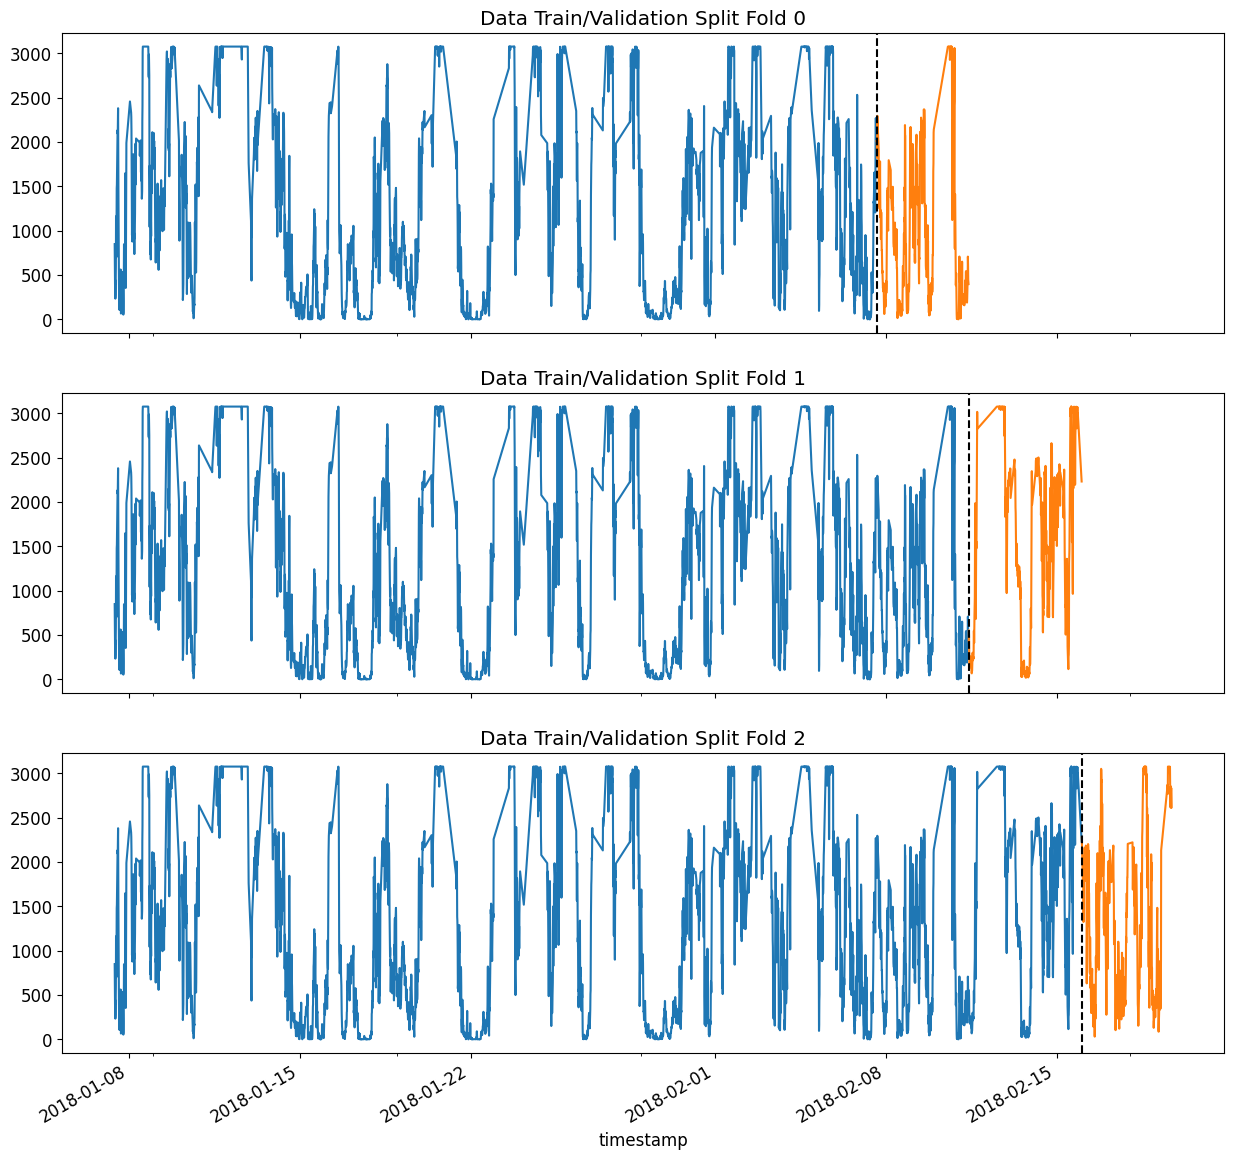

In [146]:
fig, axs = plt.subplots(n_cv, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in split.split(X_train):
    train = y_train.iloc[train_idx]
    test = y_train.iloc[val_idx]
    train.plot(ax=axs[fold],
                          label='Training',
                          title=f'Data Train/Validation Split Fold {fold}')
    test.plot(ax=axs[fold],
                         label='Validation')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Hyperparameter tuning

In [20]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from time import time

paramGrid = {
            'gamma':[1, 5, 10, 25, 50, 100, 200, 300, 500],
            'n_estimators':[500, 750, 1000],
            "max_depth":[4,6,8,10],
            'learning_rate':[.1,.01,.05,.005],
            'subsample':[1,.9,.8,.7,.6,.5],
            'reg_lambda':[1,1.1,2,1.5, 3, 5],
            'reg_alpha':[0,.1,.5,1, 1.5, 3, 5],
            'min_child_weight':[1,2,5,10,20,30,50,80, 100],
            'nthread':[20]
        }

model = xgb.XGBRegressor()

n_iter_search = 30
# gridsearch = RandomizedSearchCV(model,param_distributions=paramGrid,
#                                 cv=TimeSeriesSplit(n_splits=5).get_n_splits([X_train,y_train]),
#                                 scoring='neg_mean_absolute_error',
#                                 n_iter=n_iter_search)
gridsearch = BayesSearchCV(model, paramGrid,
                                 cv=TimeSeriesSplit(n_splits=n_cv).get_n_splits([X_train,y_train]),
                                 scoring='neg_mean_absolute_error',
                                 n_iter=n_iter_search)
start = time()
gridsearch.fit(X_train,y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))

print(gridsearch.best_params_)
print(gridsearch.best_score_)

RandomizedSearchCV took 225.36 seconds for 30 candidates parameter settings.
OrderedDict([('gamma', 300), ('learning_rate', 0.005), ('max_depth', 6), ('min_child_weight', 80), ('n_estimators', 1000), ('nthread', 20), ('reg_alpha', 0.5), ('reg_lambda', 5), ('subsample', 0.9)])
-437.60151730240915


In [21]:
from sklearn.metrics import mean_absolute_error
best_params = gridsearch.best_params_
best_params['eval_metric'] = mean_absolute_error
best_params['early_stopping_rounds'] = 10
print(best_params)

OrderedDict([('gamma', 300), ('learning_rate', 0.005), ('max_depth', 6), ('min_child_weight', 80), ('n_estimators', 1000), ('nthread', 20), ('reg_alpha', 0.5), ('reg_lambda', 5), ('subsample', 0.9), ('eval_metric', <function mean_absolute_error at 0x7b5a311d4180>), ('early_stopping_rounds', 10)])


Build model

In [147]:
train_split = [tr for tr, val in split.split(X_train)]
val_split = [val for tr, val in split.split(X_train)]

In [148]:
fold = 0
models = []
for i,(train_idx, val_idx) in enumerate(split.split(X_train)):
  X_tr = X_train.iloc[train_idx]
  X_val = X_train.iloc[val_idx]
  y_tr = y_train.iloc[train_idx]
  y_val = y_train.iloc[val_idx]

  clf = xgb.XGBRegressor(**best_params)
  clf.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_val, y_val)],
          verbose=1)
  models.append(clf)

[0]	validation_0-rmse:1083.95132	validation_0-mean_absolute_error:950.55267	validation_1-rmse:905.04098	validation_1-mean_absolute_error:784.21411
[1]	validation_0-rmse:1079.72478	validation_0-mean_absolute_error:947.01080	validation_1-rmse:902.95973	validation_1-mean_absolute_error:782.76318
[2]	validation_0-rmse:1075.53696	validation_0-mean_absolute_error:943.50671	validation_1-rmse:900.67273	validation_1-mean_absolute_error:781.07971
[3]	validation_0-rmse:1071.38561	validation_0-mean_absolute_error:940.00452	validation_1-rmse:898.57179	validation_1-mean_absolute_error:779.60736
[4]	validation_0-rmse:1067.27069	validation_0-mean_absolute_error:936.53332	validation_1-rmse:896.50289	validation_1-mean_absolute_error:778.17706
[5]	validation_0-rmse:1063.17159	validation_0-mean_absolute_error:933.11072	validation_1-rmse:894.46283	validation_1-mean_absolute_error:776.80267
[6]	validation_0-rmse:1059.09802	validation_0-mean_absolute_error:929.70715	validation_1-rmse:892.20111	validation_1-m

In [149]:
train_maes = pd.DataFrame([models[i].evals_result()['validation_0']['mean_absolute_error'] for i in range(n_cv)]).T
val_maes = pd.DataFrame([models[i].evals_result()['validation_1']['mean_absolute_error'] for i in range(n_cv)]).T


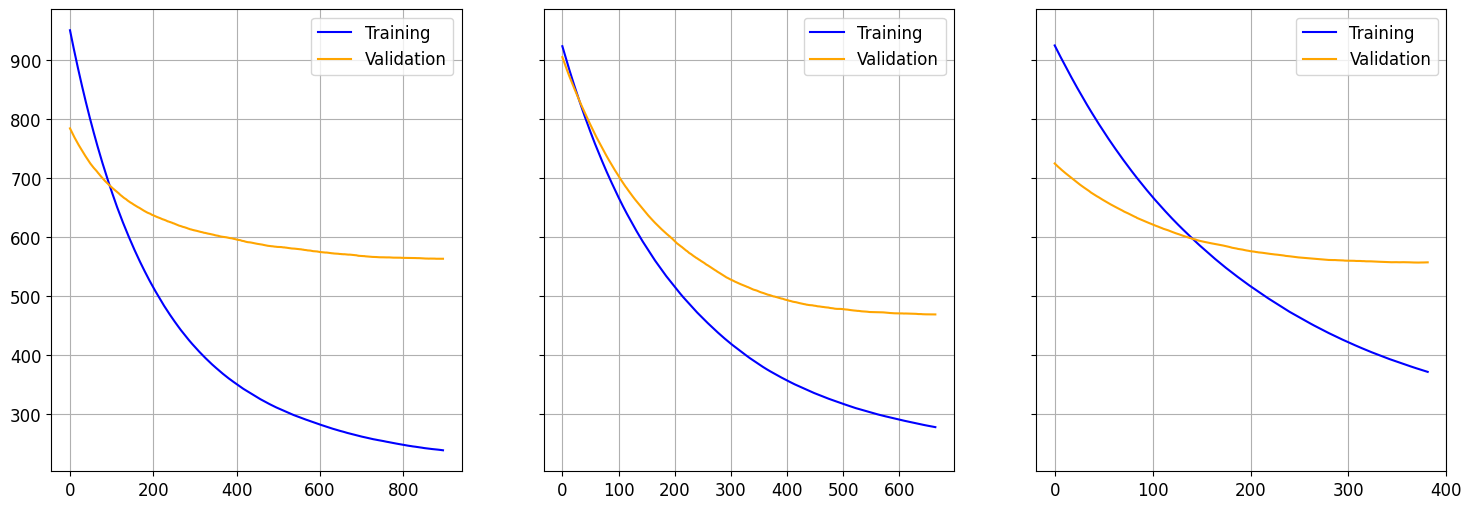

In [150]:
fig, axes = plt.subplots(1, n_cv, figsize=(6*n_cv,6), sharey=True)
for i in range(n_cv):
  train_maes[i].plot(label='Training',color='b',ax=axes[i])
  val_maes[i].plot(label='Validation',color='orange',ax=axes[i])
  axes[i].legend()
  axes[i].grid()
# As training sample increase, overfitting decrease

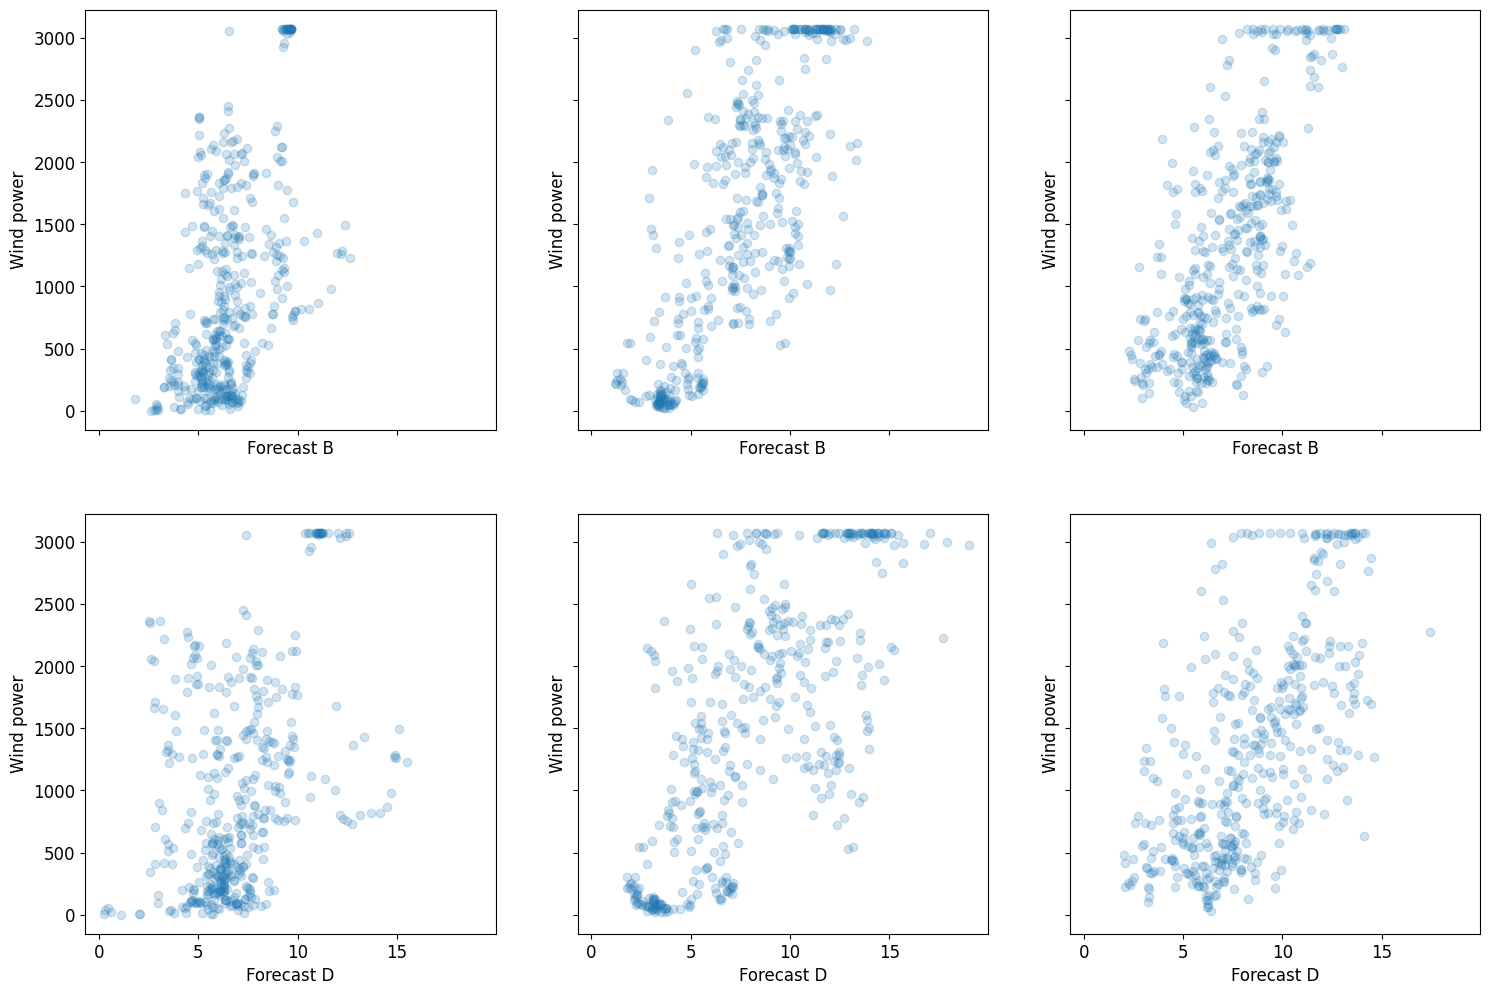

In [151]:
fig, axes = plt.subplots(2,n_cv,figsize=(6*n_cv,12),sharey=True, sharex=True)
n=0
for j in ['Forecast B', 'Forecast D']:
  for i in range(n_cv):
    axes.flatten()[n].scatter(x=X_train[j].iloc[val_split[i]],
            y=y_train.iloc[val_split[i]], label=i, alpha=0.2)
    axes.flatten()[n].set_xlabel(j)
    axes.flatten()[n].set_ylabel('Wind power')
    # axes.flatten()[n].legend()
    n+=1
# the 1st validation set is somewhat different from the other two, which may explain
# higher level of overfitting

In [152]:
feature_importance = pd.DataFrame(np.concatenate([m.feature_importances_ for m in models]).reshape(n_cv,-1),
                                  columns=X_tr.columns)
feature_importance
# Forecast B is overwhelmingly important according to Xgboost's built-in feature importance
# cosine hour is also somewhat important

,Forecast B,Forecast C,Forecast D,Forecast E,Meansurement_A_T-10,cos_hour,sin_hour,cos_Forecast A,sin_Forecast A
0,0.66,0.03,0.08,0.03,0.02,0.10,0.03,0.02,0.03
1,0.68,0.03,0.05,0.03,0.03,0.10,0.03,0.03,0.03
2,0.71,0.03,0.04,0.03,0.02,0.09,0.03,0.02,0.03


In [153]:
import shap
shap_values = {}
for i,m in enumerate(models):
  explainer = shap.Explainer(m)
  shap_values[i]=explainer(X_test)

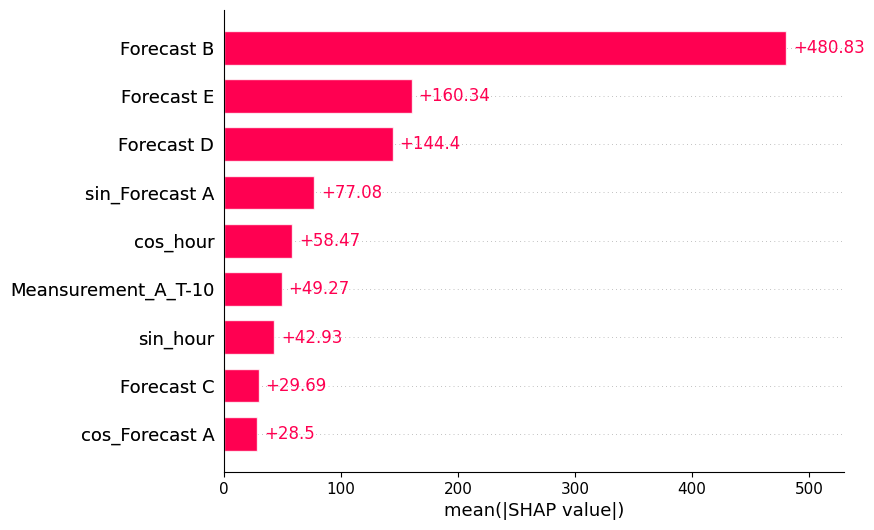

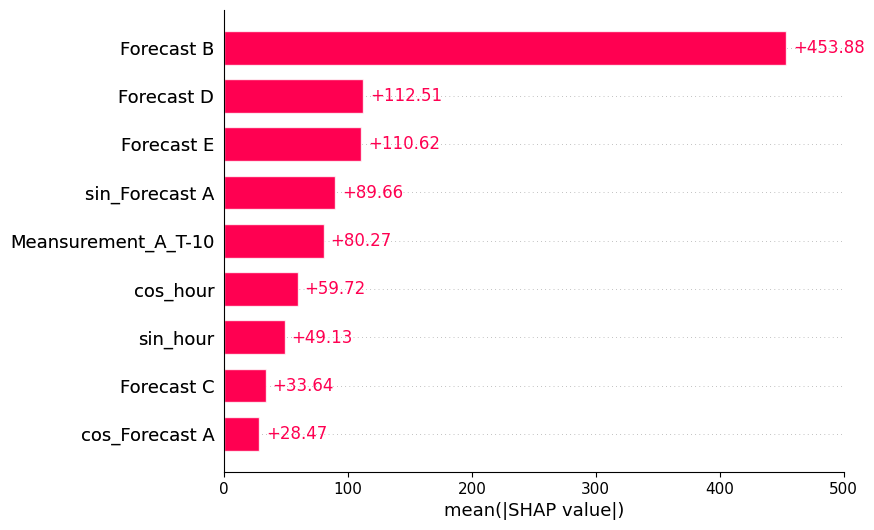

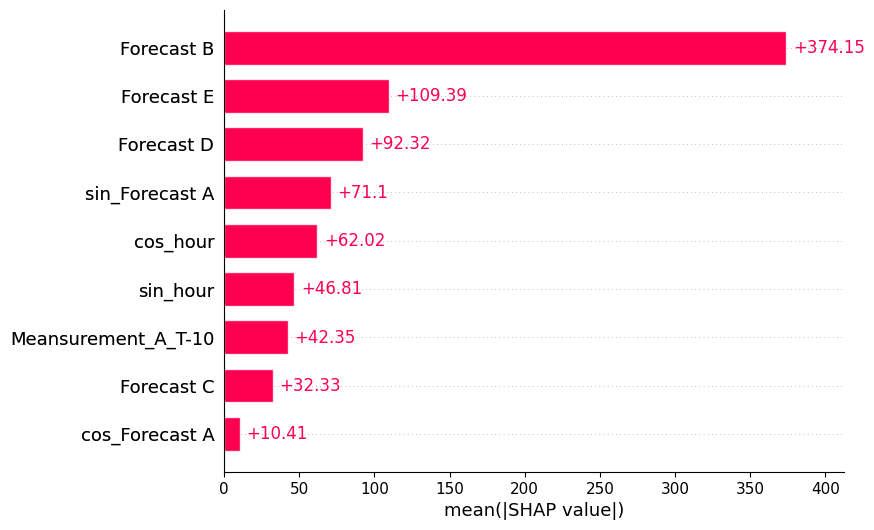

In [154]:
for i in range(n_cv):
  shap.plots.bar(shap_values[i])

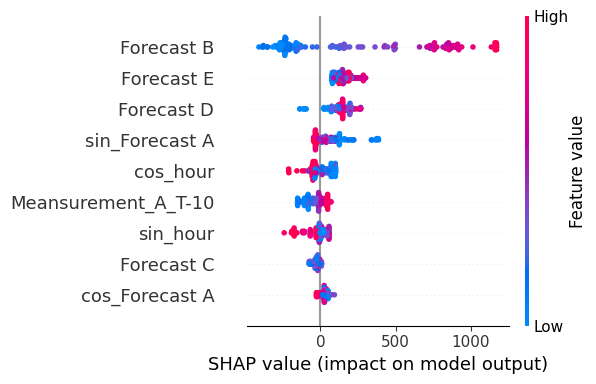

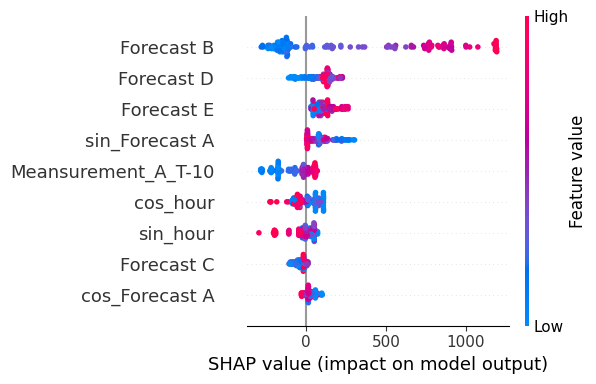

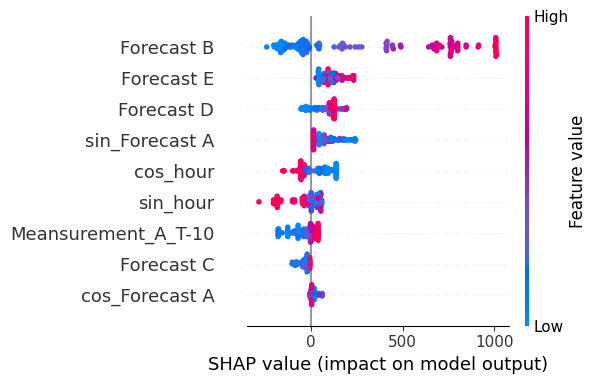

In [155]:
# Shap values reveal forecast C is least important
for i in range(n_cv):
  shap.summary_plot(shap_values[i], plot_size=(6,4))

In [156]:
features = ['sin_Forecast A', 'Forecast B', 'Forecast D', 'Forecast E', 'Meansurement_A_T-10', 'cos_hour', 'sin_hour']

Exercise 3: choose a type of model (regression, some machine learning algo, etc) that has the features of your choice as inputs and a 10hr-ahead wind power as output.
Train your model and let it compute a 10hr-ahead forecast as an example.
Provide comments explaining what your lines of code do.

In [157]:
# fit the model on all data
X_train_all = X_train[features]
X_test_all = X_test[features]
clf = xgb.XGBRegressor(**best_params)
clf.fit(X_train_all, y_train,
          eval_set=[(X_train_all, y_train), (X_test_all, y_test)],
          verbose=1)

[0]	validation_0-rmse:1043.37484	validation_0-mean_absolute_error:905.08264	validation_1-rmse:824.26957	validation_1-mean_absolute_error:702.26752
[1]	validation_0-rmse:1039.53070	validation_0-mean_absolute_error:901.93188	validation_1-rmse:822.80256	validation_1-mean_absolute_error:701.06641
[2]	validation_0-rmse:1035.70713	validation_0-mean_absolute_error:898.80951	validation_1-rmse:820.83920	validation_1-mean_absolute_error:699.41864
[3]	validation_0-rmse:1031.92099	validation_0-mean_absolute_error:895.70526	validation_1-rmse:818.90832	validation_1-mean_absolute_error:697.80810
[4]	validation_0-rmse:1028.15287	validation_0-mean_absolute_error:892.63648	validation_1-rmse:817.25544	validation_1-mean_absolute_error:696.54950
[5]	validation_0-rmse:1024.44899	validation_0-mean_absolute_error:889.63904	validation_1-rmse:815.50511	validation_1-mean_absolute_error:695.20825
[6]	validation_0-rmse:1020.73690	validation_0-mean_absolute_error:886.61359	validation_1-rmse:813.76081	validation_1-m

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7b5a311d4180>,
             feature_types=None, gamma=300, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.005, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=80, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, nthread=20, num_parallel_tree=None, ...)

In [158]:
# make prediction with test data
y_pred = pd.Series(clf.predict(X_test[features]),index=y_test.index,name='prediction')

# inverse scaling to get the real prediction and
# the orignal testing data
df_predict = pd.concat([y_pred, y_test],axis=1)
df_predict

,prediction,cleaned_Wind_power_measurements
timestamp,,
2018-02-19 17:10:00+00:00,2080.38,2074.7
2018-02-19 17:20:00+00:00,2080.38,2011.1
2018-02-19 17:30:00+00:00,2080.38,2265.9
2018-02-19 17:50:00+00:00,2080.38,2785.3
2018-02-19 18:00:00+00:00,2080.38,1811.0
...,...,...
2018-02-20 22:40:00+00:00,1754.26,1241.9
2018-02-20 22:50:00+00:00,1754.26,1595.8
2018-02-20 23:00:00+00:00,1755.99,1564.4


<Axes: xlabel='timestamp'>

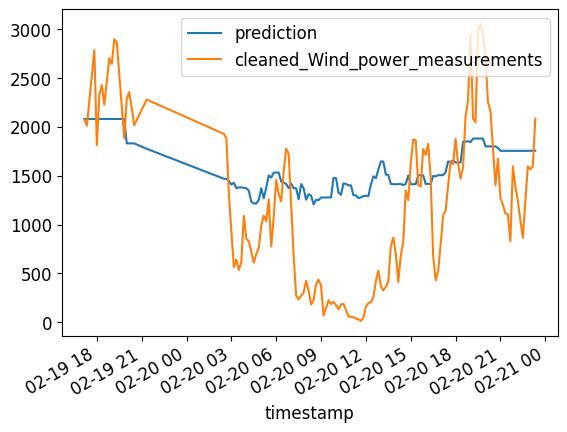

In [159]:
df_predict.plot()

Exercise 4: Compute the Mean Absolute Error (MAE) of your model.
Suggest other ways of computing accuracy than MAE.
Discuss in detail the performance of your model, using the MAE value. Give suggestions why the model is accurate or inaccurate and how you could further improve.
Note: it is of course OK if your model in this short exercise is not the most accurate or otherwise state-of-the-art, since our main goal is to assess your reasoning!

In [160]:
mae = (df_predict['prediction'] - df_predict['cleaned_Wind_power_measurements']).abs().mean()
print(f"10hr forecast mae is: {mae}")

10hr forecast mae is: 626.2995607852936


In [161]:
# we can also evaluate the forecasts by RMSE and bias
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(df_predict['cleaned_Wind_power_measurements'].values, df_predict['prediction'].values)
print(f"10hr forecast rmse is: {rmse}")

bias = df_predict['prediction'].mean() - df_predict['cleaned_Wind_power_measurements'].mean()
print(f"10hr forecast bias is: {bias}")

10hr forecast rmse is: 551770.9748690225
10hr forecast bias is: 374.5551548269059


In [162]:
# Alternatively, we can also evaluate the forecasts
# by comparing them with persistence forecasts,
# i.e. substitue the forecast values with the observed
# generation 10-hours ago
idx = pd.date_range(start=data.index[0], end=data.index[-1], freq='10min')
reindexed_data = data.reindex(idx)
df_predict['persistence'] = reindexed_data['cleaned_Wind_power_measurements'].shift(periods=6*10).loc[df_predict.index]

In [163]:
mae_persist = (df_predict['persistence'] - df_predict['cleaned_Wind_power_measurements']).abs().mean()
print(f"10hr persistence forecast mae is: {mae_persist}")

10hr persistence forecast mae is: 1174.6448305064234


In [164]:
# we can define a forecast skill score as following:
# (1 - (value / ref_value)) * 100
# so the skill score of the forecasts compared to
# persistence forecasts is:
skill_score = 1-(mae/mae_persist)
print(f"forecast skill score is: {skill_score}")

forecast skill score is: 0.46681793124200976


Summary
The test mae of the 10-hr forecast for 24 hours is about 20%, which is not the best performance. Some of the reasons could be:

1.   Data is in 10-minute granularity so the model is overfitting to the noise. The model can benefit from more training data;
2.   The crude data cleaning could be removing some valid data points. A more refined method could be helpful
3.   The input features are forecasts themselves, which adds another layer of uncertainty. The global NWP models (even local models) could be struggling model the actual local meteorological conditions.

